# Introduction

Metadata adata with cell type labels : /home/tchari/metadata/bus_stim.h5ad

Loom file with all cell types (in seawater control only): /home/tchari/counts/clytia_stim/loom/clytia_SWall_allGenes.loom

Script where I made loom files: https://github.com/tarachari3/perturbCME/blob/main/scripts/concatLoomsClytia.py

Notebook where I plot genes that change over development for nematocytes (also called cnidocytes in notebook): https://github.com/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/CellAtlasAnalysis/fullTrajAnalysis.ipynb
concatLoomsClytia.py
<https://github.com/tarachari3/perturbCME|tarachari3/perturbCME>tarachari3/perturbCME | Added by GitHub
fullTrajAnalysis.ipynb

# Preparation

In [1]:
%cd ..

# restrict numpy to use only one core, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from RADOM.inference import Trajectory
from RADOM.preprocess import *
from RADOM.plotting import *

/home/mffang/workspace/Poisson-regression


In [2]:
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import scanpy as sc
import cmasher as cmr
import copy

In [3]:
def select_genes(adata):
    idx = (adata.layers["unspliced"].toarray().var(0) > 0) & (adata.layers["spliced"].toarray().var(0) > 0)
    U=adata.layers["unspliced"][:,idx].toarray()
    S=adata.layers["spliced"][:,idx].toarray()
    n,p = S.shape
    
    X = U + S
    X_cov = np.cov(X,rowvar=False)
    X_mean = np.mean(X,axis=0)
    X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
    s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
    print("s estimated by normalized covariance of total counts =", str(s1))
    
    X_total = X.sum(0)
    s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
    print("s estimated by total counts =", str(s2))
    
    X_bar = np.mean(X,axis=0)
    X_var = np.var(X,axis=0)
    a=1
    s=s1
    Pgene_mask = (X_bar > 0) & (np.abs(X_var/(a*X_bar + s*X_bar**2)-1) < 0.1)
    Pgenes = adata.var_names[idx][Pgene_mask]

    plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
    plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
    plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'CV')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc="upper right")
    
    read_depth =  X[:,Pgene_mask].sum(1)
    rd = read_depth/read_depth.mean()
    
    U_mean = adata.layers["unspliced"].toarray().mean(0)
    S_mean = adata.layers["spliced"].toarray().mean(0)
    U_var = adata.layers["unspliced"].toarray().var(0)
    S_var = adata.layers["spliced"].toarray().var(0)
    idx = (U_mean > 0.01) & (S_mean > 0.01) \
        & (np.abs(np.log10(S_mean/U_mean)) < 2) \
        & (U_var/(a*U_mean + s*U_mean**2) > 1.1) \
        & (S_var/(a*S_mean + s*U_mean**2) > 1.1)
    X=np.zeros((n,idx.sum(),2))
    X[:,:,0]=adata.layers["unspliced"][:,idx].toarray()
    X[:,:,1]=adata.layers["spliced"][:,idx].toarray()
    fitted_genes=adata.var_names[idx]
    X.shape
    
    return X, fitted_genes, rd

## Load data

In [4]:
metafile = "/home/tchari/metadata/bus_stim.h5ad"
loomfile = "/home/tchari/counts/clytia_stim/loom/clytia_SWall_allGenes.loom"
metadata = sc.read(metafile)
alldata = sc.read(loomfile)

/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
metadata.obs

,batch,n_counts,n_countslog,louvain,condition,orgID,cellRanger_louvain,annos,annosSub
index,,,,,,,,,
AAACCCAAGAGCGACT-1,0,2423.0,3.384353,5,SW,3,1,Epidermal/Muscle,Exumbrella Epidermis
AAACCCAAGGCTCACC-1,0,10179.0,4.007705,1,DI,6,6,Neural,Neural Cells Early Stages
AAACCCAAGGGTACAC-1,0,17855.0,4.251760,1,KCl,11,11,Nematocyte,Early Nematocytes
AAACCCACACATGAAA-1,0,1830.0,3.262451,5,KCl,11,21,Nematocyte,Mechanosensory Cells-B
AAACCCACACCCTAAA-1,0,3852.0,3.585686,7,KCl,11,24,Gastroderm,GastroDigestive-F
...,...,...,...,...,...,...,...,...,...
TTTGTTGAGGGAGGTG-2,1,2633.0,3.420451,3,DI,5,7,Gastroderm,GastroDigestive-B
TTTGTTGAGTGTTCCA-2,1,11215.0,4.049799,12,SW,3,15,Gastroderm,GastroDigestive-D
TTTGTTGGTCCCTAAA-2,1,5748.0,3.759517,1,DI,8,11,Nematocyte,Early Nematocytes


In [6]:
meta_mask = [np.where(metadata.obs_names == index)[0][0] for index in alldata.obs["Barcode"]]
print(len(meta_mask))
alldata.obs["annos"] = metadata.obs["annos"][meta_mask].tolist()
alldata.obs["annosSub"] = metadata.obs["annosSub"][meta_mask].tolist()
alldata.obs["louvain"] = metadata.obs["louvain"][meta_mask].tolist()
alldata.obsm["X_pca"] = metadata.obsm["X_pca"][meta_mask]
alldata.obsm["X_tsne"] = metadata.obsm["X_tsne"][meta_mask]
alldata.obsm["X_umap"] = metadata.obsm["X_umap"][meta_mask]
alldata

5251


AnnData object with n_obs × n_vars = 5251 × 45872
    obs: 'Barcode', 'obs_names', 'annos', 'annosSub', 'louvain'
    var: 'var_names'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'matrix', 'spliced', 'unspliced'

## Select cells

In [53]:
set(alldata.obs["annosSub"])

{'Early Nematocytes',
 'Endodermal Plate',
 'Exumbrella Epidermis',
 'GastroDigestive-A',
 'GastroDigestive-B',
 'GastroDigestive-C',
 'GastroDigestive-D',
 'GastroDigestive-E',
 'GastroDigestive-F',
 'Gland Cells-A',
 'Gland Cells-B',
 'Gland Cells-C',
 'Gland Cells-D',
 'Gland Cells-E',
 'Gonad Epidermis',
 'Late Nematocytes',
 'Manubrium Epidermis',
 'Maturing/mature Nematocytes',
 'Mechanosensory Cells Early Stages',
 'Mechanosensory Cells-A',
 'Mechanosensory Cells-B',
 'Medium Oocytes',
 'Nematocyte Precursors',
 'Neural Cells Early Stages',
 'Neural Cells-A (incl. GLWa, MIH cells)',
 'Neural Cells-B (incl. RFamide cells)',
 'Neural Cells-C (incl. YFamide cells)',
 'Radial Smooth Muscles',
 'Small Oocytes',
 'Striated Muscle of Subumbrella',
 'Striated Muscle of Velum',
 'Tentacle Bulb Distal Gastroderm',
 'Tentacle Epidermis',
 'Tentacle GFP Cells',
 'Very Early Oocytes',
 'i-Cells'}

In [7]:
adata = alldata[alldata.obs["annosSub"].isin(["i-Cells","Late Nematocytes","Early Nematocytes","Maturing/mature Nematocytes","Nematocyte Precursors"])]

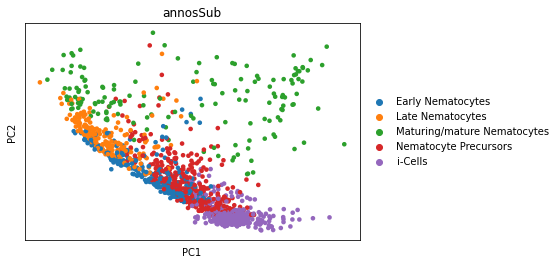

In [228]:
sc.pl.pca(adata,color=["annosSub"])

In [153]:
x = adata.obsm['X_pca']
x[:,0] *= -1

# Select genes

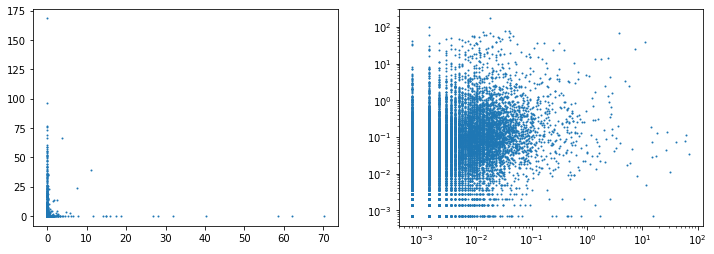

In [172]:
### check U and S means ###
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [190]:
idx = (adata.layers["unspliced"].toarray().mean(0) > 0) & (adata.layers["spliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
n,p = S.shape

X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))

X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

X = U + S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.7452361393694701
s estimated by normalized covariance of total S counts = 0.8929210593027731
s estimated by normalized covariance of total counts = 0.8137722821513307
s estimated by total counts = 0.7501328949079055


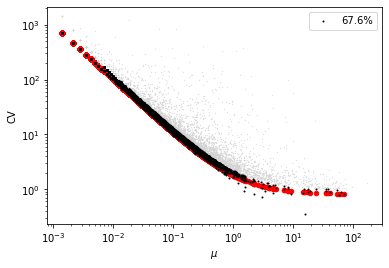

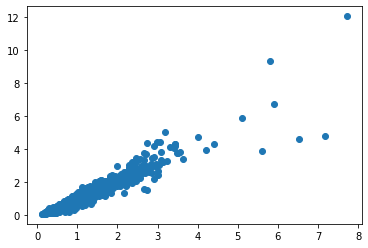

In [209]:
X_bar = np.mean(U + S,axis=0)
X_var = np.var(U + S,axis=0)
a=1
s=s1
Pgene_mask = (X_bar > 0) & (X_var/(a*X_bar + s*X_bar**2) < 1.2)
Pgenes = adata.var_names[idx][Pgene_mask]

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

plt.figure()
plt.scatter(rd,adata.X.toarray().mean(1)/adata.X.toarray().mean())

/tmp/ipykernel_4073466/482410720.py:6: RuntimeWarning: divide by zero encountered in true_divide
  & (np.abs(np.log10(S_mean/U_mean)) < 2) \
/tmp/ipykernel_4073466/482410720.py:6: RuntimeWarning: invalid value encountered in true_divide
  & (np.abs(np.log10(S_mean/U_mean)) < 2) \
/tmp/ipykernel_4073466/482410720.py:6: RuntimeWarning: divide by zero encountered in log10
  & (np.abs(np.log10(S_mean/U_mean)) < 2) \
/tmp/ipykernel_4073466/482410720.py:7: RuntimeWarning: invalid value encountered in true_divide
  & (U_var/(a*U_mean + su*U_mean**2) > 1.1) \
/tmp/ipykernel_4073466/482410720.py:8: RuntimeWarning: invalid value encountered in true_divide
  & (S_var/(a*S_mean + ss*S_mean**2) > 1.1)
/tmp/ipykernel_4073466/482410720.py:11: RuntimeWarning: divide by zero encountered in true_divide
  ax[0].scatter(S_mean, a/S_mean + ss, c='r', s=20)
/tmp/ipykernel_4073466/482410720.py:12: RuntimeWarning: invalid value encountered in true_divide
  ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',a

(1424, 562, 2)

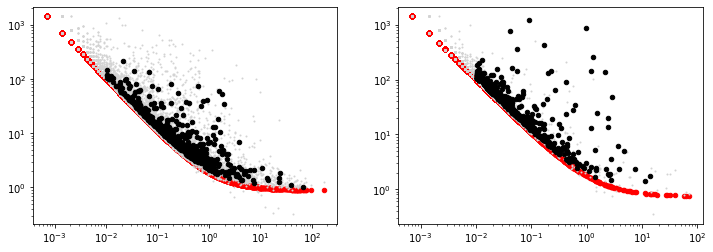

In [210]:
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.01) & (S_mean > 0.01) \
    & (np.abs(np.log10(S_mean/U_mean)) < 2) \
    & (U_var/(a*U_mean + su*U_mean**2) > 1.1) \
    & (S_var/(a*S_mean + ss*S_mean**2) > 1.1)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + ss, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + su, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

X=np.zeros((n,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

In [211]:
marker_genes = ['XLOC_044122','XLOC_008048','XLOC_030068','XLOC_011074','XLOC_041365',
                'XLOC_041836','XLOC_011949','XLOC_015554','XLOC_039385','XLOC_045474',
                'XLOC_004102','XLOC_043404','XLOC_005363','XLOC_039341','XLOC_017845',
                'XLOC_018627','XLOC_011922','XLOC_003773','XLOC_011100','XLOC_019170']
#marker_genes = ['XLOC_015554','XLOC_044122','XLOC_045474','XLOC_004102','XLOC_039385','XLOC_011100','XLOC_039341']

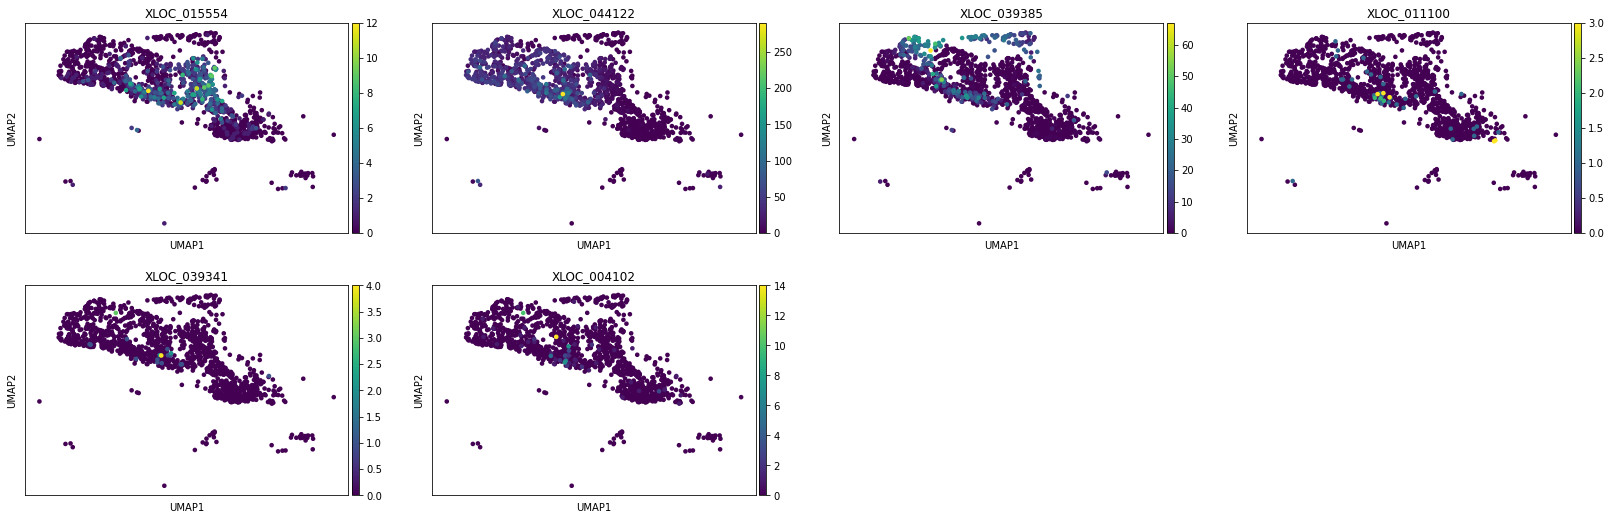

In [212]:
sc.pl.umap(adata,color=['XLOC_015554','XLOC_044122','XLOC_039385','XLOC_011100','XLOC_039341','XLOC_004102'])

In [213]:
plot_mask = fitted_genes.isin(marker_genes)
plot_idx = np.arange(len(fitted_genes))[plot_mask]
print(fitted_genes[plot_mask])
#SOCS-like

Index(['XLOC_045474', 'XLOC_015554'], dtype='object', name='Gene')


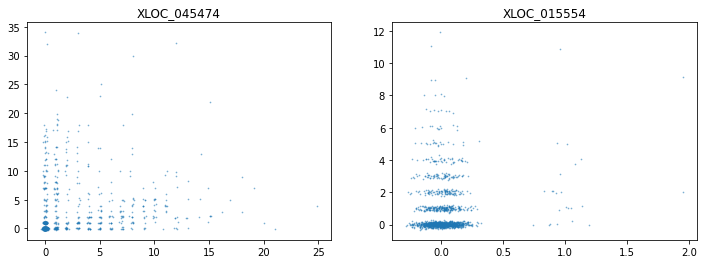

In [214]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

# Fitting

In [215]:
params={"r":rd,"lambda_tau":0,"lambda_a":0}

In [216]:
topo = np.array([[0,1,2,3]])
tau = (0,16,24,48)
traj = Trajectory(topo, tau, model="two_species_ss", verbose=1)
traj = traj.fit(X,params=params,epoch=10,perm_theta=True,n_init=1,parallel=True,n_threads=4,seed=4)

fitting with multiple random initializations
trial 1


100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


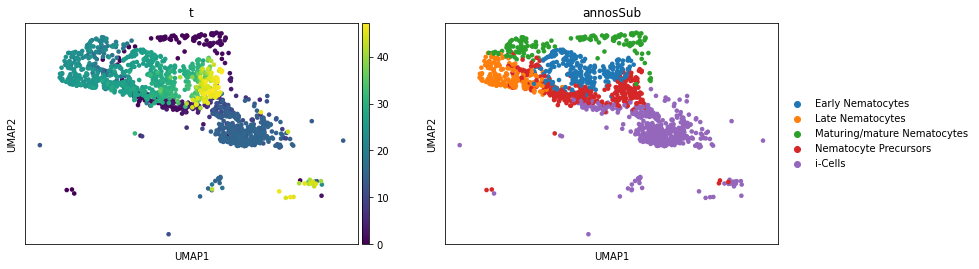

In [217]:
adata.obs["t"]=traj.Q[:,0]@traj.t
sc.pl.umap(adata,color=["t","annosSub"])

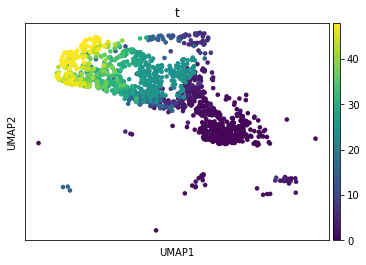

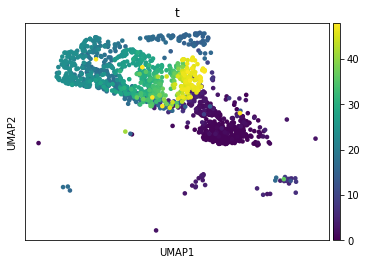

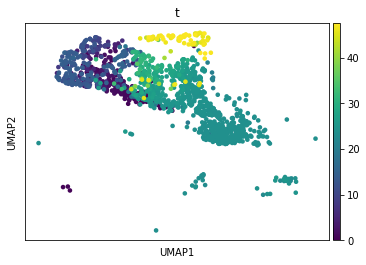

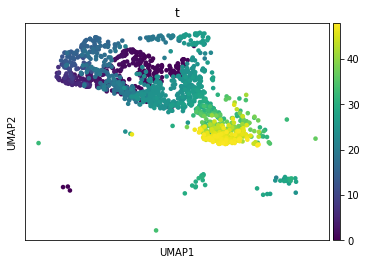

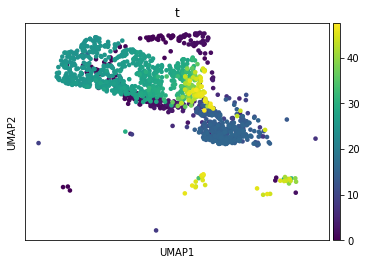

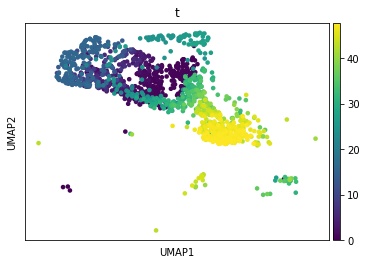

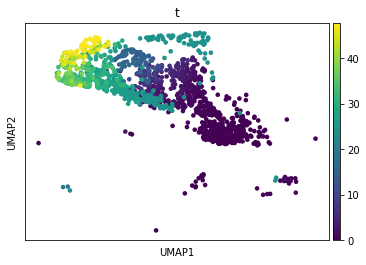

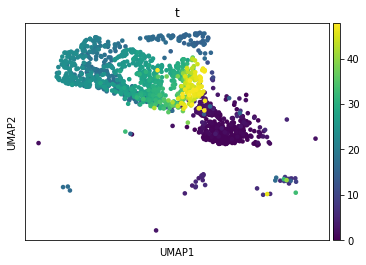

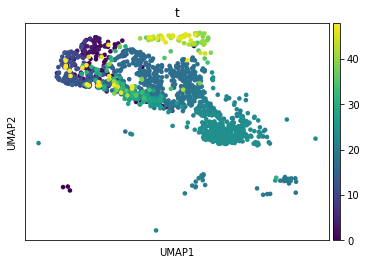

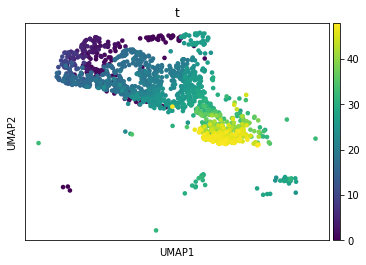

In [225]:
trajs = []

for seed in range(10):
    topo = np.array([[0,1,2,3]])
    tau = (0,16,24,48)
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,params=params,epoch=100,perm_theta=False,n_init=1,parallel=True,n_threads=10,seed=seed)
    trajs.append(traj)
    adata.obs["t"]=traj.Q[:,0]@traj.t
    sc.pl.umap(adata,color=["t"])

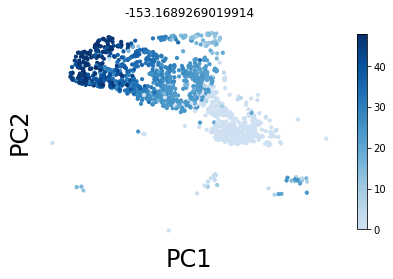

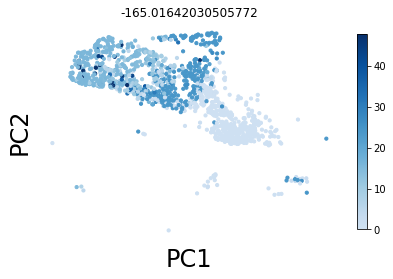

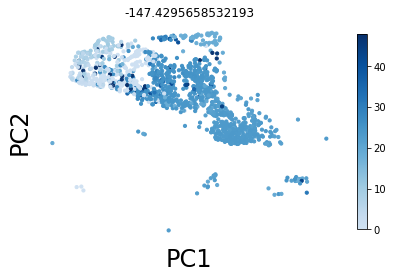

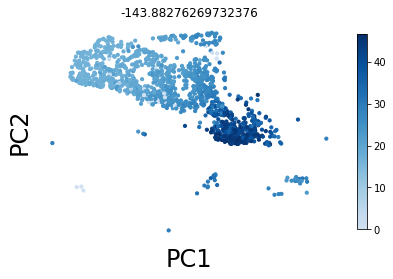

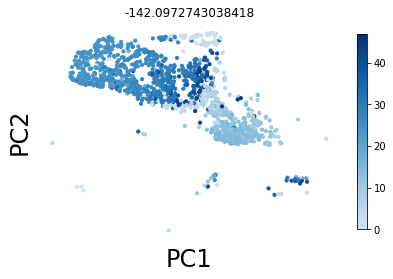

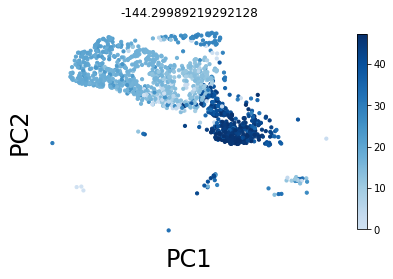

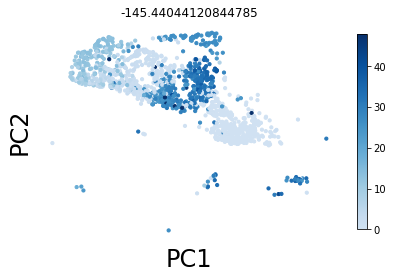

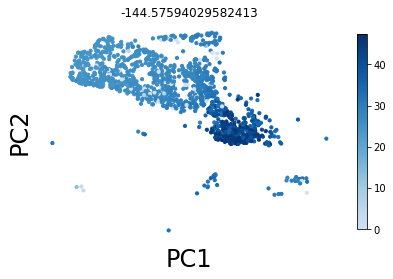

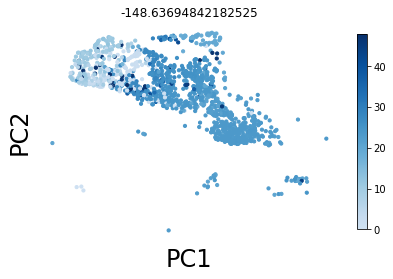

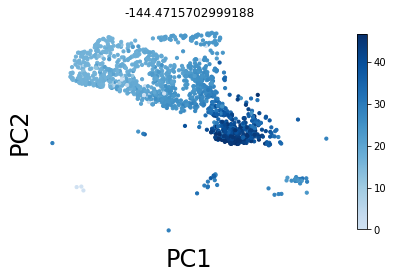

In [164]:
for traj in trajs:
    cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
    fig, ax = plt.subplots(1,1)
    im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y,s=10);
    ax.set_xlabel('PC1',fontsize=24)
    ax.set_ylabel('PC2',fontsize=24)
    ax.set_frame_on(False)
    plt.xticks([]);
    plt.yticks([]);
    plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right
    plt.title(traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )

Text(0.5, 1.0, '-142.0972743038418')

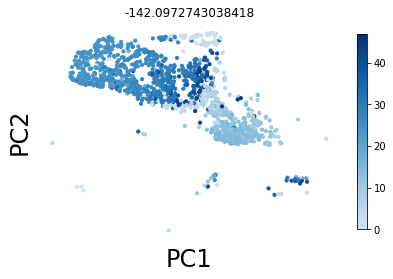

In [171]:
traj = trajs[4]
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y,s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right
plt.title(traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )

(<Figure size 864x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'XLOC_045474'}>,
        <AxesSubplot:title={'center':'XLOC_015554'}>], dtype=object))

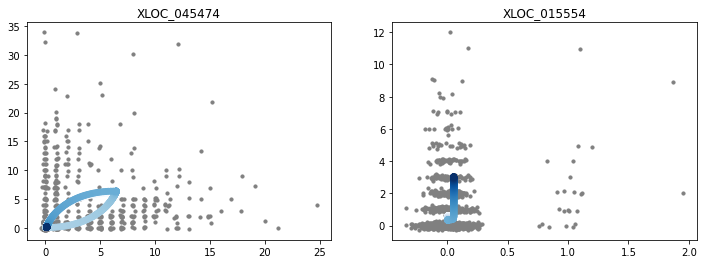

In [218]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes)

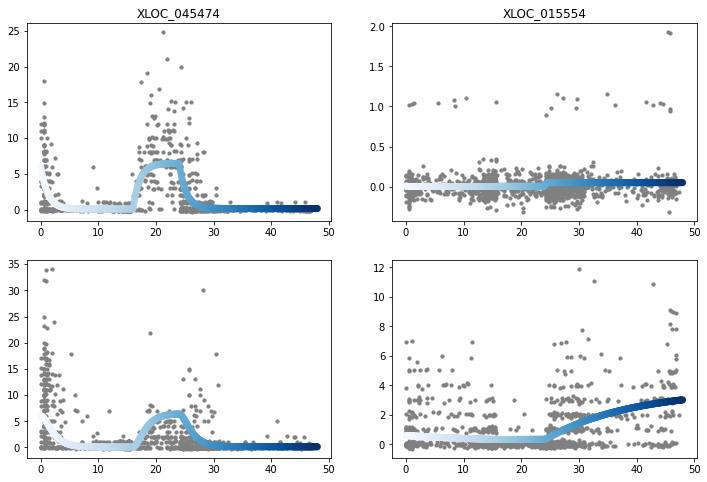

In [220]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes)

In [221]:
marker_genes = ['XLOC_015554','XLOC_044122','XLOC_039385','XLOC_011100','XLOC_039341','XLOC_004102']

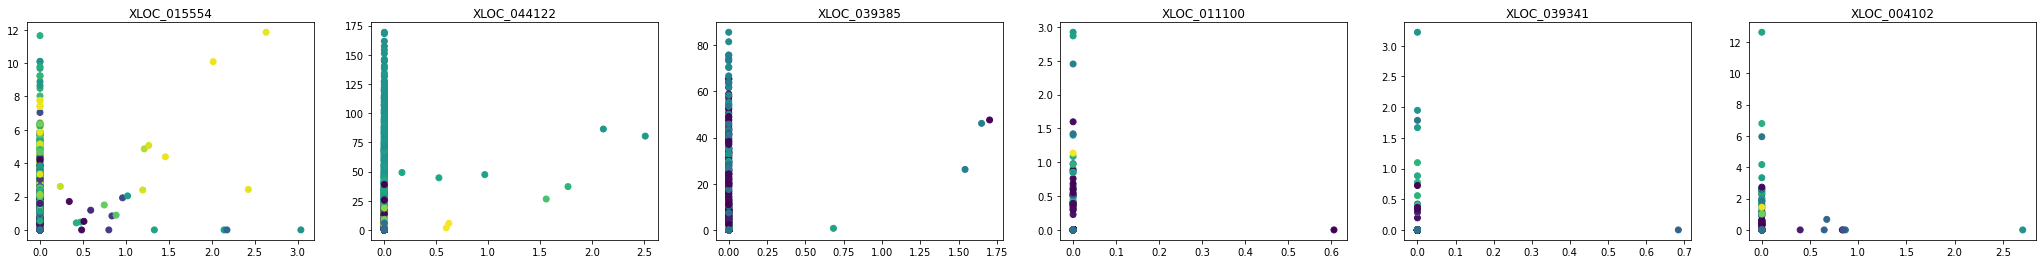

In [223]:
fig,ax = plt.subplots(1,len(marker_genes),figsize=(6*len(marker_genes),4))
for i,gene in enumerate(marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

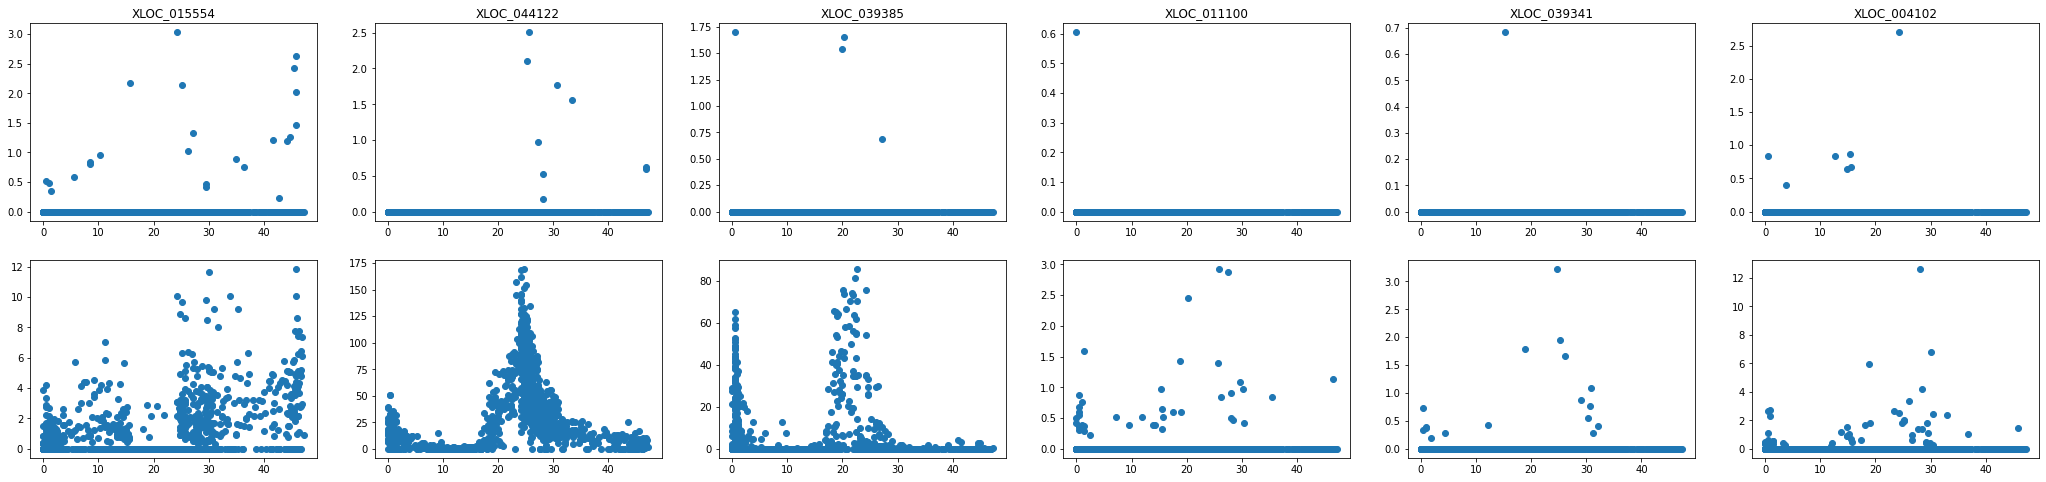

In [224]:
fig,ax = plt.subplots(2,len(marker_genes),figsize=(6*len(marker_genes),8))
for i,gene in enumerate(marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

In [19]:
topo = np.array([[0,1]])
tau=(0,1,2)
traj = Trajectory(topo, tau, model="two_species", verbose=1)
traj = traj.fit(X,n_init=10,epoch=20,parallel=True,n_threads=10)
traj.compute_AIC(X)

run method fit_multi_init
trial 1


100%|██████████| 20/20 [00:07<00:00,  2.53it/s]

trial 2



100%|██████████| 20/20 [00:07<00:00,  2.71it/s]

trial 3



 65%|██████▌   | 13/20 [00:05<00:03,  2.23it/s]


KeyboardInterrupt: 

In [ ]:
data.obs["t"]=traj.Q[:,0]@traj.t
sc.pl.umap(data,color=["t","annosSub"])

In [ ]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes)

In [ ]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes)

# Warm start

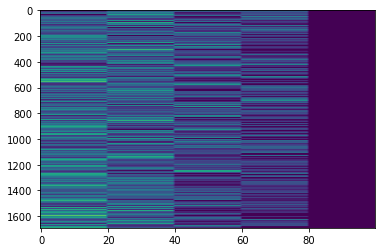

In [25]:
m=100
t_grids=np.linspace(0,2,m)
weight0 = np.ones((data.n_obs,m))
C =len(celltypes)
for i,celltype in enumerate(celltypes):
    idx = data.obs["annosSub"].isin([celltype])
    weight0[idx,int(i*m/C):int((i+1)*m/C)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]
plt.imshow(Q0[:,0],aspect="auto")

In [30]:
topo = np.array([[0,1]])
tau=(0,1,2)
traj_ = Trajectory(topo, tau, model="two_species", verbose=1)
res = traj_.fit(X,Q=Q0,epoch=20,parallel=True,n_threads=4)

run method fit_warm_start


100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


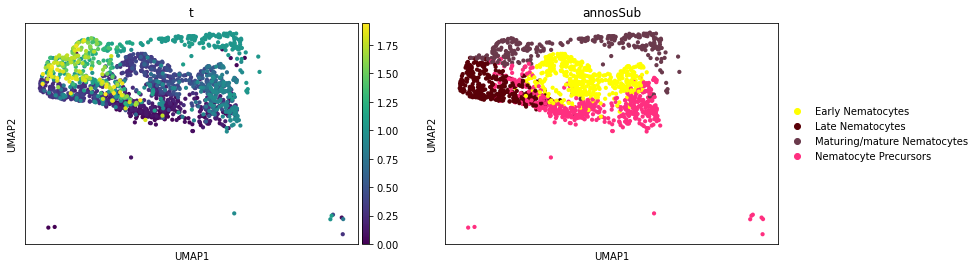

In [31]:
data.obs["t"]=traj_.Q[:,0]@traj_.t
sc.pl.umap(data,color=["t","annosSub"])

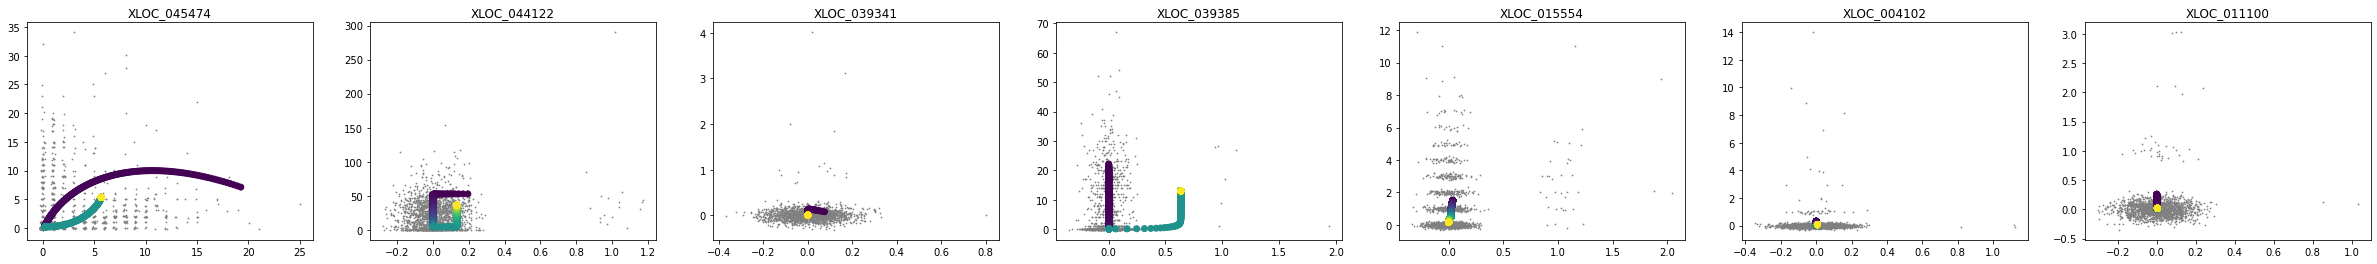

In [32]:
plot_phase(traj_,idx=plot_idx,gene_name=fitted_genes)

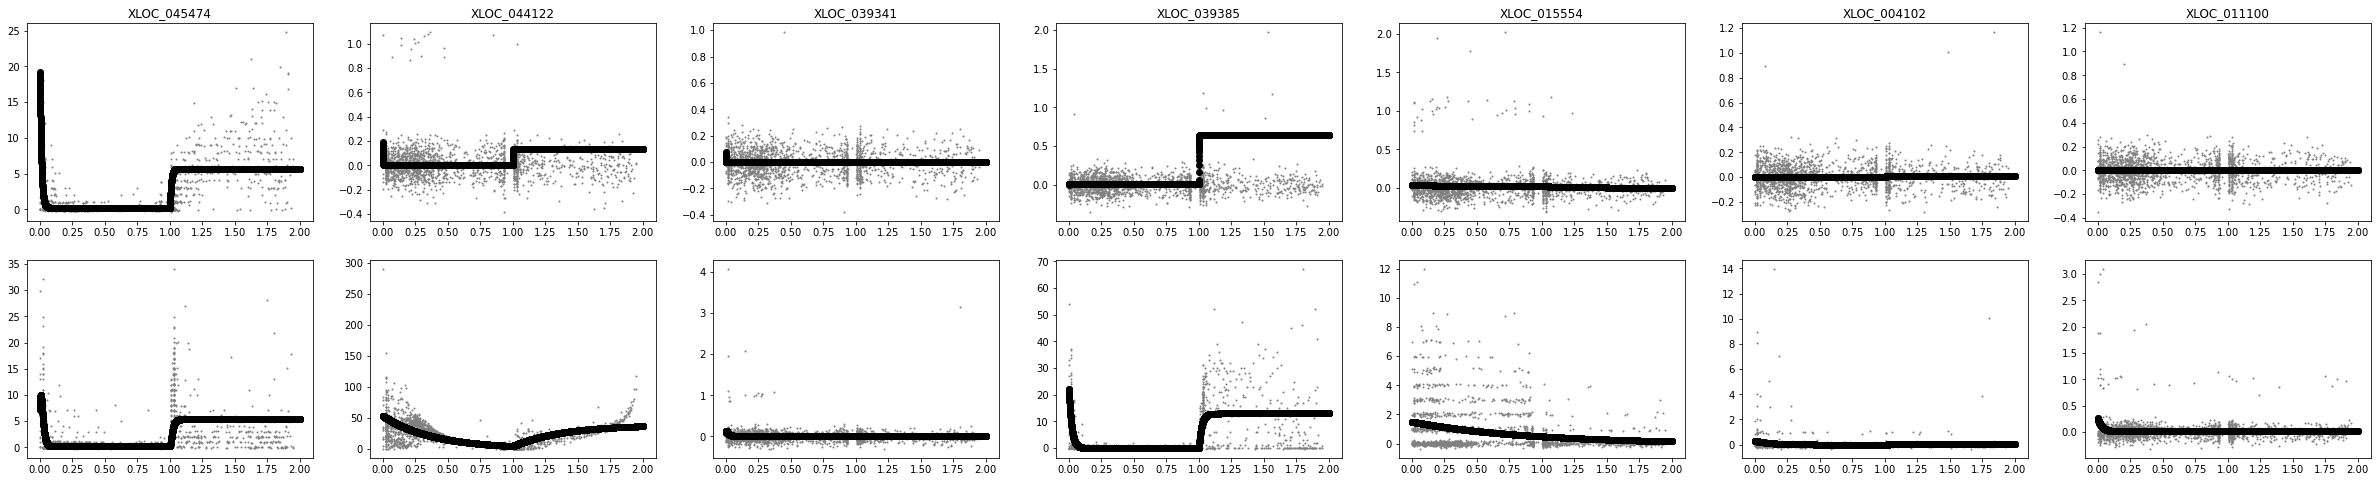

In [33]:
plot_y(traj_,idx=plot_idx,gene_name=fitted_genes)